In [ ]:
print("Hello!")

In [9]:
import json
import subprocess
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display, Markdown
import os

# Настройка графиков для ноутбука
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['font.size'] = 12

class NotebookOscillator:
    def __init__(self):
        self.simulator_path = "./oscillator_simulator"
        self.config = {
            "initial_position": 10.0,
            "initial_velocity": 0.0,
            "dt": 0.001,
            "w": 10.0,
            "simulation_time": 50.0,
            "output_file": "results.csv",
            "method": "RK4"
        }
        self.results = None
    
    def compile_simulator(self):
        result = subprocess.run([
            "g++", "-std=c++17", "-O3", "oscillator.cpp", 
            "-o", self.simulator_path
        ], capture_output=True, text=True)
        
        if result.returncode == 0:
            display(Markdown("Симулятор успешно скомпилирован!"))
            return True
        else:
            display(Markdown("Ошибка компиляции:"))
            print(result.stderr)
            return False
    
    def set_parameters(self, **kwargs):
        for key, value in kwargs.items():
            if key in self.config:
                self.config[key] = value
    
    def show_parameters(self):
        display(Markdown("Текущие параметры симуляции"))
        params_df = pd.DataFrame([self.config])
        display(params_df)
    
    def run_simulation(self, config_file="config.json"):
        # Проверяем наличие симулятора
        if not os.path.exists(self.simulator_path):
            if not self.compile_simulator():
                return False
        
        # Сохраняем конфигурацию
        with open(config_file, 'w') as f:
            json.dump(self.config, f, indent=2)
                
        # Запускаем симуляцию
        result = subprocess.run([
            self.simulator_path, config_file
        ], capture_output=True, text=True)
        
        if result.returncode == 0:
            display(Markdown("Симуляция завершена успешно!"))
            self._load_results()
            return True
        else:
            display(Markdown("Ошибка симуляции:"))
            print(result.stderr)
            return False
    
    def _load_results(self):
        output_file = self.config["output_file"]
        df = pd.read_csv(output_file)
        self.results = df
    
    def analyze(self):
        if self.results is None:
            display(Markdown("Сначала запустите симуляцию!"))
            return
        
        display(Markdown("Анализ результатов"))
        
        initial_energy = self.results['energy'].iloc[0]
        final_energy = self.results['energy'].iloc[-1]
        energy_drift_percent = ((final_energy - initial_energy) / initial_energy) * 100
        
        analysis_data = {
            "Параметр": ["Метод", "Время симуляции", "Шаг времени", 
                        "Начальная энергия", "Конечная энергия", 
                        "Дрейф энергии", "Макс. положение", "Макс. скорость"],
            "Значение": [
                self.config["method"],
                f"{self.config['simulation_time']} с",
                f"{self.config['dt']} с",
                f"{initial_energy:.6f}",
                f"{final_energy:.6f}",
                f"{energy_drift_percent:.6f}%",
                f"{np.max(np.abs(self.results['position'])):.4f}",
                f"{np.max(np.abs(self.results['velocity'])):.4f}"
            ]
        }
        
        analysis_df = pd.DataFrame(analysis_data)
        display(analysis_df)
    
    def plot_results(self):
        """Построение графиков результатов"""
        if self.results is None:
            display(Markdown("Нет данных для построения графиков!"))
            return
        
        display(Markdown("Графики результатов"))
        
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
        
        # Положение от времени
        ax1.plot(self.results['time'], self.results['position'], 'b-', linewidth=2)
        ax1.set_xlabel('Время (с)')
        ax1.set_ylabel('Положение')
        ax1.set_title('Положение от времени')
        ax1.grid(True, alpha=0.3)
        
        # Скорость от времени
        ax2.plot(self.results['time'], self.results['velocity'], 'r-', linewidth=2)
        ax2.set_xlabel('Время (с)')
        ax2.set_ylabel('Скорость')
        ax2.set_title('Скорость от времени')
        ax2.grid(True, alpha=0.3)
        
        # Фазовый портрет
        ax3.plot(self.results['position'], self.results['velocity'], 'g-', linewidth=1)
        ax3.set_xlabel('Положение')
        ax3.set_ylabel('Скорость')
        ax3.set_title('Фазовый портрет')
        ax3.grid(True, alpha=0.3)
        
        # Энергия
        ax4.plot(self.results['time'], self.results['energy'], 'purple', linewidth=2)
        ax4.set_xlabel('Время (с)')
        ax4.set_ylabel('Энергия')
        ax4.set_title('Сохранение энергии')
        ax4.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def compare_methods(self):
        """Сравнение методов RK4 и Euler"""
        display(Markdown("Сравнение методов интегрирования"))
        
        methods = ["RK4", "Euler"]
        results = {}
        
        for method in methods:
            display(Markdown(f"Запуск метода {method}"))
            
            self.set_parameters(
                method=method,
                output_file=f"results_{method}.csv"
            )
            
            if self.run_simulation():
                results[method] = self.results.copy()
                
                # Быстрый анализ
                energy_drift = ((self.results['energy'].iloc[-1] - self.results['energy'].iloc[0]) / 
                               self.results['energy'].iloc[0]) * 100
                display(Markdown(f"Дрейф энергии ({method}): **{energy_drift:.6f}%**"))
        
        # Сравнительный график
        if len(results) > 1:
            display(Markdown("равнение энергии"))
            
            plt.figure(figsize=(12, 6))
            for method, data in results.items():
                plt.plot(data['time'], data['energy'], label=method, linewidth=2)
            
            plt.xlabel('Время (с)')
            plt.ylabel('Энергия')
            plt.title('Сравнение сохранения энергии')
            plt.legend()
            plt.grid(True, alpha=0.3)
            plt.show()

# Создаем экземпляр симулятора
sim = NotebookOscillator()

In [10]:
# Показываем текущие параметры
sim.show_parameters()

# Настраиваем параметры
sim.set_parameters(
    initial_position=5.0,    # Начальное положение
    w=8.0,                   # Частота
    simulation_time=20.0,    # Время симуляции
    dt=0.001,               # Шаг времени
    method="RK4"            # Метод (RK4 или Euler)
)

# Показываем обновленные параметры
sim.show_parameters()

Текущие параметры симуляции

,initial_position,initial_velocity,dt,w,simulation_time,output_file,method
0,10.0,0.0,0.001,10.0,50.0,results.csv,RK4


Текущие параметры симуляции

,initial_position,initial_velocity,dt,w,simulation_time,output_file,method
0,5.0,0.0,0.001,8.0,20.0,results.csv,RK4


Симулятор успешно скомпилирован!

Симуляция завершена успешно!

Анализ результатов

,Параметр,Значение
0,Метод,RK4
1,Время симуляции,20.0 с
2,Шаг времени,0.001 с
3,Начальная энергия,800.000000
4,Конечная энергия,799.998000
5,Дрейф энергии,-0.000250%
6,Макс. положение,5.0000
7,Макс. скорость,40.0000


Графики результатов

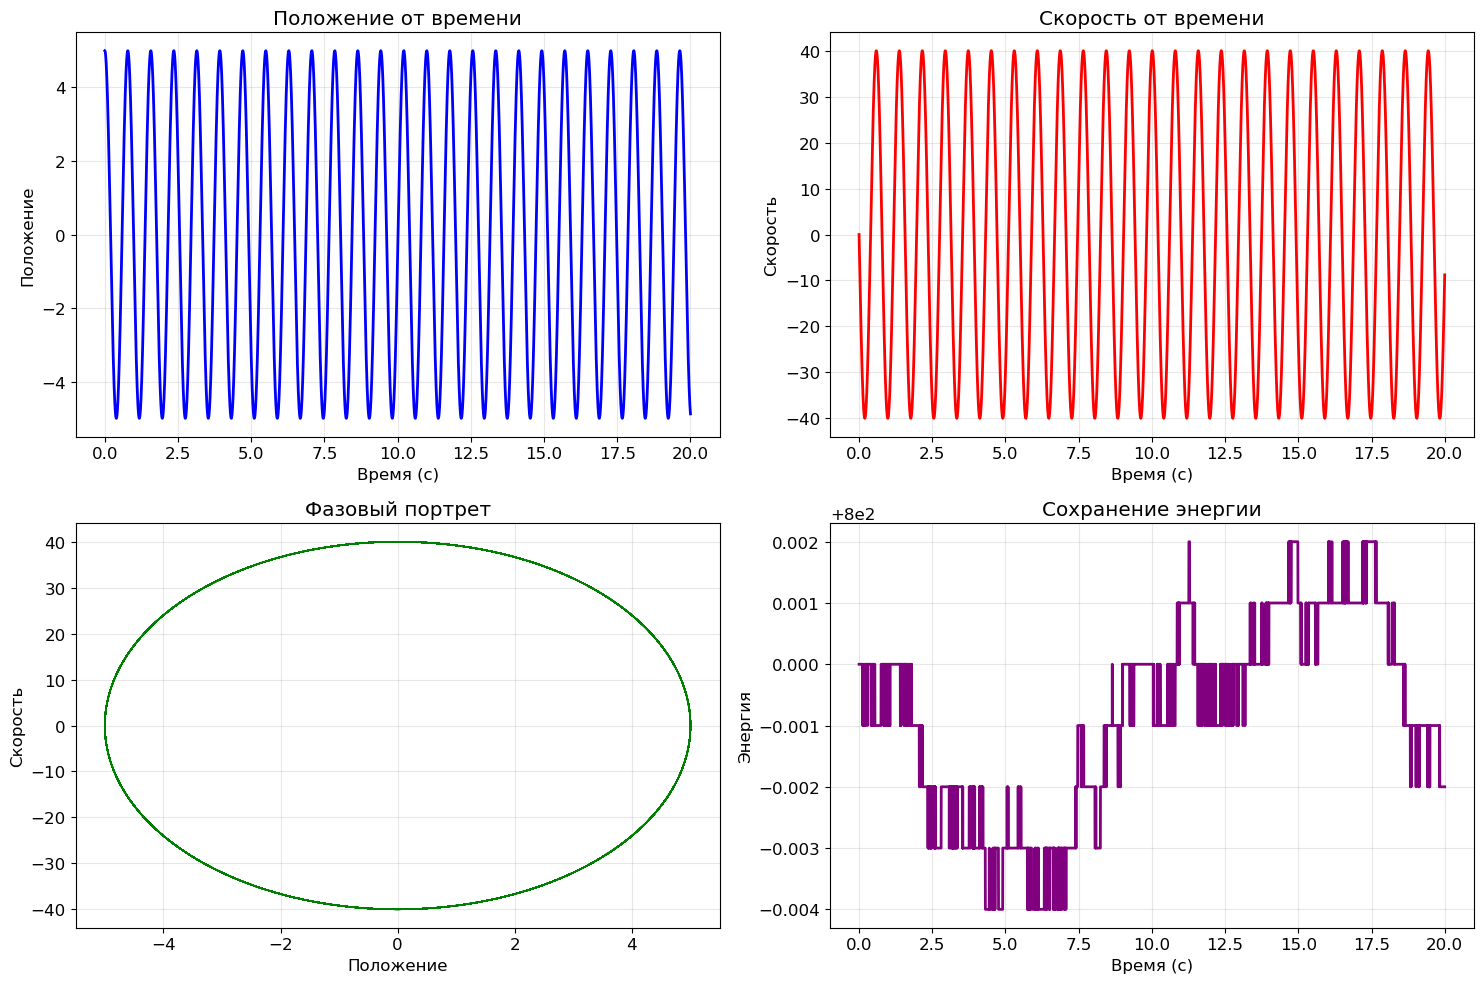

In [ ]:
# Запускаем симуляцию
if sim.run_simulation():
    # Анализируем результаты
    sim.analyze()
    
    # Строим графики
    sim.plot_results()

Сравнение методов интегрирования

Запуск метода RK4

Симуляция завершена успешно!

Дрейф энергии (RK4): **-0.000250%**

Запуск метода Euler

Симуляция завершена успешно!

Дрейф энергии (Euler): **0.001375%**

равнение энергии

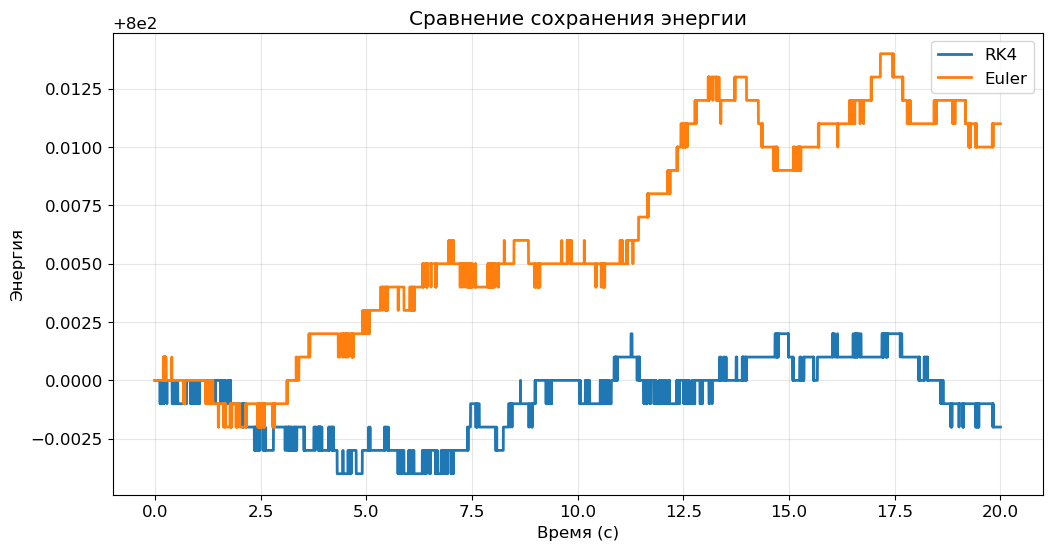

In [12]:
# Сравниваем RK4 и Euler
sim.compare_methods()

In [13]:
# Исследуем влияние разных частот
frequencies = [5, 10, 15]

for w in frequencies:
    display(Markdown(f"### 🔬 Частота w = {w}"))
    
    sim.set_parameters(
        w=w,
        output_file=f"results_w{w}.csv",
        method="RK4"
    )
    
    if sim.run_simulation():
        sim.analyze()
        print("\n")

### 🔬 Частота w = 5

Симуляция завершена успешно!

Анализ результатов

,Параметр,Значение
0,Метод,RK4
1,Время симуляции,20.0 с
2,Шаг времени,0.001 с
3,Начальная энергия,312.500000
4,Конечная энергия,312.501000
5,Дрейф энергии,0.000320%
6,Макс. положение,5.0000
7,Макс. скорость,25.0001


### 🔬 Частота w = 10

Симуляция завершена успешно!

Анализ результатов

,Параметр,Значение
0,Метод,RK4
1,Время симуляции,20.0 с
2,Шаг времени,0.001 с
3,Начальная энергия,1250.000000
4,Конечная энергия,1250.010000
5,Дрейф энергии,0.000800%
6,Макс. положение,5.0000
7,Макс. скорость,50.0002


### 🔬 Частота w = 15

Симуляция завершена успешно!

Анализ результатов

,Параметр,Значение
0,Метод,RK4
1,Время симуляции,20.0 с
2,Шаг времени,0.001 с
3,Начальная энергия,2812.500000
4,Конечная энергия,2812.510000
5,Дрейф энергии,0.000356%
6,Макс. положение,5.0000
7,Макс. скорость,75.0001
